<div class="alert alert-block alert-danger">
注意：本 notebook 使用的 lightfm Python 包不支持 Python 3.12!
请使用 Python 3.11 运行此 notebook。
</div>

版权所有 © 2022 Gurobi Optimization, LLC

# 使用数学优化的音乐推荐系统 

一首好歌永远不会过时，除非真的过时了。
像 Spotify 这样的音乐流媒体服务会定期为其数百万用户提供精心策划的音乐推荐，以保持用户继续使用服务的兴趣。这些推荐需要真正引起用户共鸣，同时还要引入新颖性来保持用户的好奇心。

在本 notebook 中，我们将介绍如何使用预测分析和规范分析的组合来创建音乐推荐系统。
预测组件基于用户过去的音乐偏好来预测他们可能喜欢什么，而规范组件则使用这些预测来创建最优多样化的推荐列表。

**目标**：为用户推荐新的艺人，使这些艺人既令人喜欢又具有多样性。


本 notebook 使用的数据集是从两个 Kaggle 数据集预处理而来：
- [加密的用户数据 (Pichl, Zangerle 和 Specht, 2015)](https://www.kaggle.com/datasets/andrewmvd/spotify-playlists)，包含 [Spotify](https://open.spotify.com/) 用户创建的播放列表 
- [艺人数据](https://www.kaggle.com/datasets/pieca111/music-artists-popularity)，包含从 [Musicbrainz](https://musicbrainz.org/) 和 [Last.fm](last.fm) 收集的音乐人统计信息。

Pichl, Martin; Zangerle, Eva; Specht, Günther: "面向上下文感知的音乐推荐方法：播放列表名称中隐藏了什么？" 发表于第 15 届 IEEE 国际数据挖掘研讨会论文集 (ICDM 2015)，第 1360-1365 页，IEEE，大西洋城，2015年。

## 加载数据

首先，让我们加载以下用于分析和可视化数据集的包。

In [1]:
# %pip install gurobipy seaborn lightfm
import numpy as np 
import pandas as pd 
import warnings 
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt 
import seaborn as sns

我们将首先加载包含艺人信息的数据集。该数据集包含 8,465 位艺人及其来源国家和在 [Last.fm](https://www.last.fm/) 上的听众数量的信息。每位艺人都被分配了一个从 0 到 8,465 的 ID。

In [5]:
# df_artist = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/music_recommendation/artist_data.csv')
df_artist = pd.read_csv('artist_data.csv')
print(len(df_artist),"艺人")
df_artist.head()

8465 艺人


,artist_id,artist,country,listeners
0,0,Coldplay,United Kingdom,5381567
1,1,Radiohead,United Kingdom,4732528
2,2,Red Hot Chili Peppers,United States,4620835
3,3,Rihanna,United States,4558193
4,4,Eminem,United States,4517997


让我们看看最受欢迎的 2,000 位艺人的听众数量分布。

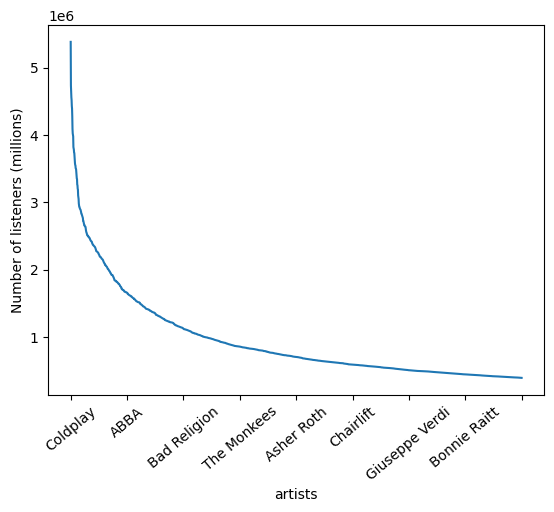

In [7]:
df_artist.set_index('artist')['listeners'].head(2000).plot(rot=40) 
plt.xlabel('artists')
plt.ylabel('Number of listeners (millions)') 
plt.show()

这些艺人来自哪里？让我们可视化每个国家的艺人数量。在这个数据集中有 102 个国家，三个最常见的来源地是：美国、英国和瑞典。

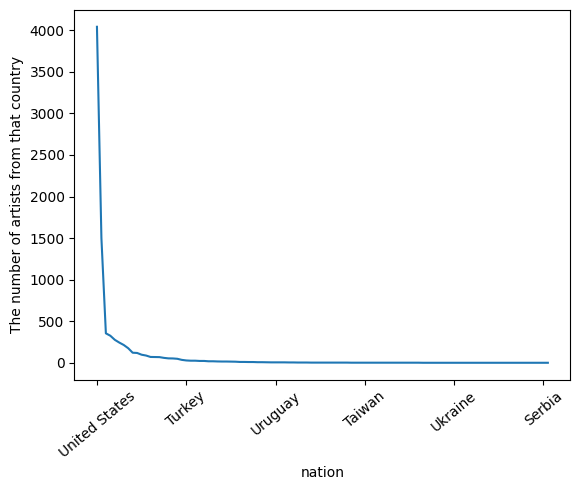

,country,count
0,United States,4041
1,United Kingdom,1500
2,Sweden,355
3,Spain,326
4,Canada,277
...,...,...
97,Saint Vincent and The Grenadines,1
98,Samoa,1
99,Guinea,1
100,Serbia,1


In [8]:
df_country = df_artist.groupby('country')['country'].count().sort_values(ascending = False).reset_index(name="count")
df_country.set_index('country')['count'].plot(rot=40) #选择至少有 100 位艺人的国家
plt.xlabel('nation')
plt.ylabel('The number of artists from that country') 
plt.show() 
df_country

接下来，加载包含用户信息的数据集，其中包括每位 1,306 位用户创建的播放列表。播放列表是来自不同艺人的音乐曲目集合。该数据集对于了解用户对艺人的偏好非常重要。播放列表中出现的某艺人曲目数量是衡量用户喜欢该艺人的一个良好指标。

In [10]:
# df_playlist = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/music_recommendation/user_playlist_data.csv')
df_playlist = pd.read_csv('user_playlist_data.csv')
print(df_playlist['user_id'].nunique(),"用户") 
df_playlist.head(50) 

1306 用户


,user_id,artist_id,artist,track,playlist
0,785,622,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,785,622,Elvis Costello,Alison,HARD ROCK 2010
2,785,622,Elvis Costello,Tramp The Dirt Down,HARD ROCK 2010
3,993,622,Elvis Costello,Don't Let Me Be Misunderstood,Everything at once
4,487,622,Elvis Costello,Alison,Home
5,300,622,Elvis Costello,Beautiful,Ángeles
6,155,622,Elvis Costello,Watching The Detectives - Single Version,Vergaarbaak
7,155,622,Elvis Costello,She,Voorbeschouwing
8,317,622,Elvis Costello,Deep Dark Truthful Mirror,We Are Hunted Paramore Chart Jan 12
9,697,622,Elvis Costello,Alison,All Time Great Songs


## 使用协同过滤训练预测模型

我们现在使用**协同过滤**训练一个预测模型来学习用户对艺人的偏好，这是一种常用于产品推荐的流行方法。其理念是使用所有其他用户的协作信息来预测一个用户的偏好。

为了在这个用户-艺人数据集上实现协同过滤，我们将使用**矩阵分解**。这里，主要输入是一个 $n \times m$ 矩阵，其中行包含 $n$ 个用户，列包含 $m$ 个艺人。矩阵中的一个元素表示该用户对该艺人的喜爱程度 - 通过艺人在其播放列表中出现的频率来衡量。这个矩阵被分解成两个维度为 $n \times d$ 和 $d \times m$ 的矩阵，其中 $d$ 是隐藏特征的数量。特征数量 $d$ 越大，模型就越复杂和细致，尽管会有过拟合的风险。点击[这里](https://towardsdatascience.com/intro-to-recommender-system-collaborative-filtering-64a238194a26)可以了解更多关于协同过滤的信息。


我们将使用 [lightfm](https://github.com/lyst/lightfm) 进行矩阵分解，如下所示。

In [ ]:
import lightfm 
from lightfm import LightFM, cross_validation
from lightfm.evaluation import auc_score  

为矩阵分解创建输入矩阵，使用艺人在每个用户的播放列表中出现的频率。

In [ ]:
# 存储艺人在用户播放列表中出现频率的数据框
df_freq = df_playlist.groupby(['user_id', 'artist']).agg('size').reset_index().rename(columns={0:'freq'})[['user_id', 'artist', 'freq']].sort_values(['freq'], ascending=False)
df_freq = df_freq.merge(df_artist[['artist_id','artist']], left_on='artist', right_on='artist') 

# 输入矩阵 
input_matrix = df_freq.groupby(['user_id', 'artist_id'])['freq'].sum().unstack().reset_index().fillna(0).set_index('user_id')

# 用于跟踪每个艺人名字的艺人ID的字典
artists_dict ={(df_artist.loc[i,'artist_id']): df_artist.loc[i,'artist'] for i in range(df_artist.shape[0])} 
df_freq.head()

,user_id,artist,freq,artist_id
0,701,The Rolling Stones,667,13
1,328,The Rolling Stones,658,13
2,351,The Rolling Stones,93,13
3,469,The Rolling Stones,77,13
4,603,The Rolling Stones,69,13


在训练预测模型之前，数据集被随机分为训练集（80%）和测试集（20%）以评估拟合效果。拟合质量通过 *ROC 曲线下面积(AUC)* 指标来衡量。这是衡量用户偏好的项目比随机项目排名更高的可能性的指标。它越接近 1，拟合效果越好。点击[这里](https://flowthytensor.medium.com/some-metrics-to-evaluate-recommendation-systems-9e0cf0c8b6cf)可以了解更多关于 AUC 分数的信息。

模型的参数包括组件(或特征)的数量、损失函数、训练轮数等。以下显示了这些参数的设置值，但你可以尝试其他值来观察它们对性能的影响。

In [8]:
### Train-Test split
from scipy import sparse
x = sparse.csr_matrix(input_matrix.values)  
train, test = lightfm.cross_validation.random_train_test_split(x, test_percentage=0.2, random_state=None)

### Train the Matrix Factorization Model  
model = LightFM(no_components=50, loss='warp')
model.fit(x, epochs=30, num_threads = 4)
 
train_auc = auc_score(model, train, num_threads=4).mean()  
test_auc = auc_score(model, test, train_interactions=train, num_threads=4).mean()
print('Train AUC: %f, test AUC: %f'%(train_auc,test_auc))

Train AUC: 0.984152, test AUC: 0.985815


## 选择用户

预测模型已经训练完成。对于本 notebook 的其余部分，我们将专注于为一个用户推荐艺人。首先，选择一个用户并获取他们对艺人的学习偏好分数(0 到 1 之间的值)。根据训练好的模型，偏好分数越高，表示对该用户的偏好越大。

要选择一个用户，请使用此单元格底部的下拉菜单从 0(默认)到 1,305 中选择一个用户 ID。

In [ ]:
from __future__ import print_function
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
  
def get_user_preference(x):  
    # 创建一个存储每个艺人偏好值(0-1之间)的字典
    global preference, df_pref
    preference = pd.Series(model.predict(x, np.arange(input_matrix.shape[1]))).to_dict()
    lower_score = min(preference.values())
    highest_score = max(preference.values())
    preference = {artists_dict[i]:(preference[i]-lower_score)/(highest_score-lower_score) for i in preference}  
     
    # 打印用户已知喜欢的艺人
    known_items = list(pd.Series(input_matrix.loc[x,:][input_matrix.loc[x,:] > 0].index).sort_values(ascending=False))
    known_items = list(pd.Series(known_items).apply(lambda x: artists_dict[x])) 
    print("该用户已经喜欢的前20位艺人:\n",known_items[:20]) 
     
    # 打印用户的预测偏好分数
    df_pref = pd.DataFrame.from_records([(k, v) for k, v in preference.items()], columns =['artist', 'preference']) 
    df_pref = df_artist.merge(df_pref,left_on='artist',right_on='artist').sort_values(by = 'preference',ascending=False)
    print("\n预测的偏好:") 

n_users = df_playlist['user_id'].nunique()
print("Select a user id from 0 through %i."%(n_users-1))
interact(get_user_preference, x=list(range(n_users)))
df_pref.head(30)

Select a user id from 0 through 1305.


interactive(children=(Dropdown(description='x', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

,artist_id,artist,country,listeners,preference
78,78,P!nk,United States,2495211,1.000000
3,3,Rihanna,United States,4558193,0.983621
52,52,Christina Aguilera,United States,2788515,0.963143
66,66,Avril Lavigne,Canada,2627363,0.960885
90,90,Kelly Clarkson,United States,2425837,0.959522
30,30,Britney Spears,United States,3255085,0.921503
62,62,Usher,United States,2650020,0.895425
269,269,Whitney Houston,United States,1607022,0.895255
28,28,The Black Eyed Peas,United States,3346410,0.885004
16,16,Katy Perry,United States,3733134,0.882295


对于我们选择的用户，我们已经得到了对艺人的预测偏好分数。看看最受欢迎的艺人，其中几位艺人非常受欢迎。例如，对于用户 0，他们最喜欢的 30 位艺人平均拥有超过一百万的听众。

In [10]:
print("The top 30 artists have %i listeners on average."% int(df_pref[['listeners']].head(30).sum()/30))

The top 30 artists have 2374392 listeners on average.


## 优化流行度多样性


但是，如果我们想推荐不那么受欢迎的艺人呢？将小众艺人添加到推荐艺人列表中可以提高推荐的**新颖性**，同时也支持较新的艺人。

我们现在引入一个数学优化模型来最优地解决偏好和流行度之间的权衡。
优化模型旨在根据**目标函数**找到**最佳解决方案**，使解决方案满足预定义的**约束条件**集合。
在这里，解决方案表示为称为**决策变量**的实数值或整数(如二进制)值的向量。
约束条件是一组写成决策变量函数的等式或不等式。
 
对于我们的模型，解决方案由选定的艺人集合给出。目标函数是最大化所选艺人的总偏好分数，以使推荐的艺人令人喜欢。为了控制所选艺人的整体流行度，我们强制要求平均流行度小于预定义的最大限制。我们还添加了一个约束条件，即艺人数量固定为预定义值。
因此，这是一个在流行度和规模约束下最大化偏好的优化模型。


让我们现在定义用于创建模型的一些输入参数和符号。下标 $a$ 将用于表示我们可以选择的所有艺人集合中的单个艺人。艺人集合、偏好和流行度来自数据集。


### 输入参数


$p_a$: 用户对艺人 $a$ 的偏好,

$q_a$: 艺人 $a$ 的流行度，以其听众数量衡量,

$N$: 要选择的艺人数量,
  
$P_{max}$: 所选艺人集合中平均流行度的最大限制。

以下代码加载 Gurobi python 包并初始化优化模型。可以在下面的单元格中更改 $N$ 和 $P_{max}$ 的值。作为示例，最大流行度限制设置为 $500,000$ 听众，艺人数量设置为 $30$。

In [ ]:
import gurobipy as gp 
from gurobipy import GRB

artists = sorted(preference.keys(),reverse=True,key=lambda x : preference[x])[:1000]  # 最受欢迎的1000位艺术家
popularity = df_artist.groupby('artist')['listeners'].apply(float).to_dict() # 每位艺术家的受欢迎程度
P_max = 500000
N = 30

m = gp.Model("Recommend artists") # 这定义了我们将在完成公式后添加的模型

Restricted license - for non-production use only - expires 2023-10-25


### 决策变量

存储优化问题解决方案的关键数据结构是*决策变量*。在我们的模型中，我们希望存储是否选择某个艺人包含在解决方案中。因此，我们为每个艺人 $a$ 定义以下*二进制决策变量*以表示我们想要做出的**是**或**否**决策。这被建模为 $x_a = 1$ 如果选择艺人 $a$；否则为 $x_a = 0$。


字典是存储决策变量的好方法。我们可以通过循环遍历每个艺人或一次性添加所有变量(如下所示的注释代码)。

In [12]:
x = {}
for a in artists:
    x[a] = m.addVar(vtype=GRB.BINARY)  
# x = m.addVars(artists,vtype=GRB.BINARY)         

### 目标

接下来，我们将定义目标函数：我们希望最大化所选艺人的总偏好。
使用二进制决策变量，目标可以写成如下形式。

\begin{align*}
\textrm{maximize} &\sum_{a} p_a x_a
\end{align*}

以下代码将目标函数添加到模型中，并告诉模型我们希望最大化该函数。

In [13]:
m.setObjective(sum(x[a]*preference[a] for a in artists), GRB.MAXIMIZE)
m.ModelSense = GRB.MAXIMIZE

### 流行度约束

我们希望确保所选艺人的平均流行度小于预定义值 $P_{max}$。此条件表示为如下约束。
 
\begin{align*}
\sum_{a} q_a x_a &\leq P_{max}  
\end{align*}

以下代码将此约束添加到模型中。

In [14]:
popularity_constraints = m.addConstr(sum(x[a]*popularity[a] for a in artists) <= P_max*N)

### 数量约束

最后，我们希望选择确切的 $N$ 个艺人。此条件表示为以下约束。

\begin{align*}
\sum_{a} x_a &= N 
\end{align*}

以下代码将此约束添加到模型中。

In [15]:
n_artists_constraints = m.addConstr(sum(x[a] for a in artists) == N)

最后，一旦所有约束都添加完毕，我们可以告诉 Gurobi 求解优化模型并找到最优解。

In [16]:
m.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 1000 columns and 2000 nonzeros
Model fingerprint: 0x5ae73861
Variable types: 0 continuous, 1000 integer (1000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+06]
  Objective range  [6e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+01, 2e+07]
Presolve time: 0.01s
Presolved: 2 rows, 1000 columns, 2000 nonzeros
Variable types: 0 continuous, 1000 integer (1000 binary)
Found heuristic solution: objective 20.9247336

Root relaxation: objective 2.320614e+01, 6 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   23.20614    0    2   20.92473   23.20614  10.9%     -    0s
H    0     0                      23.1567009   23.20614  0.21%   

优化器已解决模型。现在让我们检索最优解。变量 $x_a$ 的值可以通过代码 "x[a].X" 检索；如果 x[a].X 是 $1$，则选择艺人 $a$。

以下代码将解决方案存储为 Pandas 数据框。

In [17]:
chosen_artists = [a for a in artists if x[a].X > .99]  
dict_artist_country = dict(zip(df_artist.artist, df_artist.country))

df_chosen_artists = pd.DataFrame({'artists':chosen_artists, 'popularity':[popularity[i] for i in chosen_artists], 'preference':[preference[i] for i in chosen_artists], 'country':[dict_artist_country[i] for i in chosen_artists]})
print("Artists chosen:"%(chosen_artists))
df_chosen_artists

Artists chosen:


,artists,popularity,preference,country
0,P!nk,2495211.0,1.000000,United States
1,R. Kelly,1456472.0,0.881024,United States
2,Luther Vandross,700090.0,0.850716,United States
3,Jordin Sparks,902941.0,0.842717,United States
4,Girls Aloud,723845.0,0.835629,United Kingdom
5,Toni Braxton,918419.0,0.822874,United States
6,Brandy,859521.0,0.814069,United States
7,Savage Garden,916122.0,0.807891,Australia
8,Blue,437763.0,0.792209,United Kingdom
9,Shontelle,460620.0,0.785508,Barbados


我们可以观察到，与仅选择最受欢迎的 30 位艺人相比，这些艺人总体上更具*小众性*。虽然这种推荐在流行度方面是多样化的，但艺人主要来自少数几个国家。是否可以将国际多样性注入推荐中？

## 使用约束改善国际多样性

答案是肯定的。我们现在来看添加新的约束，强制要求所选艺人集合中应该有预定数量的国家代表。以下是一个新的输入参数，允许我们设置国际多样性的程度。

- $C_{min}$: 最少代表的国家数量

将 $C_{min}$ 设置为 $0$ 对模型没有影响，而将其设置为 $N$(选择的艺人数量)将确保所有艺人来自 $N$ 个不同的国家。以下首先定义输入。

In [ ]:
artists_in_country = df_artist[df_artist['artist'].isin(artists)].groupby('country')['artist'].apply(list).to_dict() # the set of artists from each country
countries = artists_in_country.keys() # 所有国家的集合
C_min = 20 # 0和N之间的数字

### 决策变量

为了跟踪某个国家是否被代表，为每个国家 $c$ 创建以下二进制决策变量。这被建模为 $y_c = 1$ 如果国家 $c$ 被代表；否则为 $y_c = 0$。

将变量添加到模型中。请注意，我们正在将其添加到我们之前使用的同一模型中。

In [19]:
y = m.addVars(countries, vtype=GRB.BINARY) 

### 约束 $y$ 和 $x$ 的关系

我们希望确保 $y_c$ 的值为 $0$ 如果没有选择来自国家 $c$ 的艺人。
因此，如果 $\sum_\limits{\textrm{来自国家 $c$ 的艺人}} x_a$ 的值为 $0$，我们将 $y_c$ 设置为 $0$。此条件可以表示为以下约束。

\begin{align*}
y_c  &\leq \sum_{\textrm{来自国家 $c$ 的艺人}} x_a \quad  \textrm{对于每个国家}\  c
\end{align*}

我们可以将这些约束添加到模型中。

In [20]:
country_defining_constraints = m.addConstrs((y[c] <= sum(x[a] for a in artists_in_country[c])) for c in countries)

### 国际代表性约束

最后，我们希望确保至少有 $C_{min}$ 个国家被代表，这可以表示为以下约束。
\begin{align*}
\sum_{c} y_c &\geq C_{min}
\end{align*}

我们可以将此约束添加到模型中并启动优化。

In [21]:
country_limit_constraints = m.addConstr(sum(y[c] for c in artists_in_country) >= C_min) 
m.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38 rows, 1035 columns and 3070 nonzeros
Model fingerprint: 0x68609e1d
Variable types: 0 continuous, 1035 integer (1035 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+06]
  Objective range  [6e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 2e+07]

MIP start from previous solve did not produce a new incumbent solution

Presolve removed 14 rows and 14 columns
Presolve time: 0.00s
Presolved: 24 rows, 1021 columns, 3042 nonzeros
Variable types: 0 continuous, 1021 integer (1021 binary)
Found heuristic solution: objective 20.4713302

Root relaxation: objective 2.246906e+01, 53 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   22.46906 

可视化解决方案。

30 artists in 20 countries chosen.
Represented countries: ['Australia', 'Barbados', 'Belgium', 'British Virgin Islands', 'Canada', 'Denmark', 'France', 'Germany', 'Ireland', 'Italy', 'Jamaica', 'Moldova', 'Norway', 'Philippines', 'Romania', 'South Korea', 'Spain', 'Sweden', 'United Kingdom', 'United States']


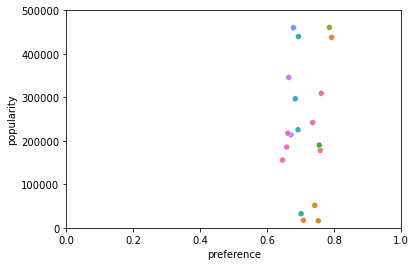

,artists,popularity,preference,country
0,R. Kelly,1456472.0,0.881024,United States
1,Luther Vandross,700090.0,0.850716,United States
2,Céline Dion,1376413.0,0.844627,Canada
3,Jordin Sparks,902941.0,0.842717,United States
4,Girls Aloud,723845.0,0.835629,United Kingdom
5,Enrique Iglesias,1549855.0,0.823422,Spain
6,Brandy,859521.0,0.814069,United States
7,Savage Garden,916122.0,0.807891,Australia
8,Blue,437763.0,0.792209,United Kingdom
9,Shontelle,460620.0,0.785508,Barbados


In [22]:
chosen_artists = [a for a in artists if x[a].X > .99]
chosen_countries = [c for c in artists_in_country if y[c].x > 0.99]
print("%i artists in %i countries chosen."%(len(chosen_artists),len(chosen_countries)))
print("Represented countries:",chosen_countries)

df_chosen_artists = pd.DataFrame({'artists':chosen_artists, 'popularity':[popularity[i] for i in chosen_artists], 'preference':[preference[i] for i in chosen_artists], 'country':[dict_artist_country[i] for i in chosen_artists]})
sns.scatterplot(data=df_chosen_artists, x="preference", y="popularity", hue="country", legend = False)
plt.xlim(0, 1)
plt.ylim(0, 500000)
plt.show()
df_chosen_artists 

我们可以清楚地看到所选艺人集合中有更多的国际多样性。

虽然本 notebook 逐步讲解了如何构建优化模型，但以下代码包含了整体优化模型。您可以为 $P_{max}$(平均流行度的最大限制)、$N$(选择的艺人数量)和 $C_{min}$(代表国家的最小限制)输入不同的参数值，并查看最优解如何变化。可以使用单元格下方的滑块控制 $P_{max}$ 的值。

如果 $P_{max}$ 太低会发生什么？流行度和喜好之间是否存在权衡？您能找到一个解决方案，其中所有艺人都来自不同的国家吗？

In [ ]:
def solve(x):
    # 艺人选择的输入参数
    P_max = x # 平均流行度的最大限制
    N = 30 # 选择的艺人数量 
    C_min = 30 # 代表国家的最小数量限制
    
    # 初始化模型 
    m = gp.Model("Playlisting")  
    
    # 定义变量
    x = m.addVars(artists,vtype=GRB.BINARY) 
    y = m.addVars(countries, vtype=GRB.BINARY) 
    
    # 定义目标函数 
    m.setObjective(sum(x[a]*preference[a] for a in artists), GRB.MAXIMIZE)
    m.ModelSense = GRB.MAXIMIZE
    
    # 添加约束条件 
    m.addConstr(sum(x[a]*popularity[a] for a in artists) <= P_max*N) # 设置平均流行度的最大限制
    m.addConstr(sum(x[a] for a in artists) == N) # 精确选择N位艺人 
      
    m.addConstrs((y[c] <= sum(x[a] for a in artists_in_country[c])) for c in countries) # 仅当选择了该国家的艺人时才选择该国家
    m.addConstr(sum(y[c] for c in artists_in_country) >= C_min) # 设置代表国家数量的最小限制
    
    m.setParam('OutputFlag', 0) # 禁止输出
    m.optimize() # 运行模型优化
    
    if m.status != 2:
        print("\n 问题无解。没有满足所有约束条件的解。")
        print("尝试增加最大流行度限制，或减少需要代表的最小国家数量。")
        return
 
    chosen_artists = [a for a in artists if x[a].X > .99] # 选中的艺人集合 
    chosen_countries = [c for c in artists_in_country if y[c].x > 0.99] # 选中的国家集合 
    print("已选择%i位来自%i个国家的艺人。"%(len(chosen_artists),len(chosen_countries)))
    print("代表的国家:",chosen_countries)

    # 创建可视化的数据框
    df_chosen_artists = pd.DataFrame({'artists':chosen_artists, 'popularity':[popularity[i] for i in chosen_artists], 'preference':[preference[i] for i in chosen_artists], 'country':[dict_artist_country[i] for i in chosen_artists]})
    sns.scatterplot(data=df_chosen_artists, x="preference", y="popularity", hue="country", legend = False)
    plt.xlim(0.6, 1)
    plt.ylim(0, 5000000)
    plt.show()
    print(df_chosen_artists)
     
print("Select a maximum limit on the average popularity:\n")
interact(solve, x=(200000,2000000,200000))

Select a maximum limit on the average popularity:



interactive(children=(IntSlider(value=1000000, description='x', max=2000000, min=200000, step=200000), Output(…

<function __main__.solve(x)>

版权所有 © 2022 Gurobi Optimization, LLC